In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import run_single as rs

Other shocks
========

We're going to run some other shock events, based on the list of identified shocks that I found. This will help fill out the model, and I can save them in a meaningful manner (pre, post, change) so that I don't have to keep running things. To start, I'll redo the Q opening to make sure I have all of the details.

In [75]:
conn = rs.create_connection()
units = rs.get_unit_list(conn)
query = rs.build_large_query(units, '2016-10-15', '2017-03-15', include_exit=False)  # ~150 day window
units[:5]

['R001', 'R003', 'R004', 'R005', 'R006']

In [76]:
print(query[:140], query[-140:], sep='\n')

select R001.date_time, R001.enter R001,
R003.enter R003,
R004.enter R004,
R005.enter R005,
R006.enter R006,
R007.enter R007,
R008.enter R008
2 on r001.date_time = R572.date_time
        where R001.date_time between '2016-10-15' and '2017-03-15'
        order by date_time asc;
    


In [77]:
data = rs.pull_data(query, conn)
data.columns = units
data.head()

,R001,R003,R004,R005,R006,R007,R008,R009,R010,R011,...,R546,R547,R548,R549,R550,R551,R552,R570,R571,R572
date_time,,,,,,,,,,,,,,,,,,,,,
2016-10-15 04:00:00-05:00,1523.0,86.0,207.0,190.0,364.0,155.0,158.0,214.0,7733.0,7067.0,...,342.0,1298.0,851.0,784.0,5813.0,875.0,503.0,NaN,NaN,NaN
2016-10-15 08:00:00-05:00,269.0,11.0,38.0,41.0,96.0,40.0,40.0,73.0,1420.0,963.0,...,104.0,0.0,0.0,516.0,129.0,205.0,594.0,NaN,NaN,NaN
2016-10-15 12:00:00-05:00,1552.0,56.0,160.0,184.0,177.0,211.0,110.0,107.0,1946.0,2797.0,...,1600.0,0.0,0.0,1933.0,815.0,1576.0,2537.0,NaN,NaN,NaN
2016-10-15 16:00:00-05:00,3177.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5214.0,8488.0,...,2116.0,0.0,0.0,2507.0,1997.0,2804.0,2727.0,NaN,NaN,NaN
2016-10-15 20:00:00-05:00,6047.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,7544.0,8411.0,...,2302.0,0.0,0.0,2136.0,1977.0,2552.0,3053.0,NaN,NaN,NaN


We need to collapse this down into daily data, which we can do easily with pandas. We have to shift the times backward by at least an hour to make sure that our daily ridership is correct, since the reading at midnight is for the riders that rode in the previous four hours.

In [78]:
data = rs.resample(data)
data.head()

,R001,R003,R004,R005,R006,R007,R008,R009,R010,R011,...,R546,R547,R548,R549,R550,R551,R552,R570,R571,R572
date,,,,,,,,,,,,,,,,,,,,,
2016-10-16,12976.0,108.0,283.0,351.0,590.0,235.0,273.0,322.0,27344.0,30944.0,...,5846.0,0.0,0.0,7403.0,5046.0,6909.0,8710.0,NaN,NaN,NaN
2016-10-17,31430.0,1581.0,4081.0,4102.0,5097.0,2912.0,2674.0,2540.0,31297.0,70049.0,...,20205.0,4022.0,4560.0,28428.0,20818.0,20112.0,21008.0,NaN,NaN,NaN
2016-10-18,31975.0,1653.0,4281.0,4172.0,5163.0,3034.0,2824.0,2662.0,34550.0,67918.0,...,21119.0,5499.0,4914.0,29025.0,34413.0,21295.0,21870.0,NaN,NaN,NaN
2016-10-19,33229.0,1658.0,4272.0,4289.0,5192.0,3027.0,2907.0,2734.0,35471.0,68624.0,...,20649.0,5869.0,5510.0,27925.0,24410.0,21185.0,21663.0,NaN,NaN,NaN
2016-10-20,31916.0,1613.0,4289.0,4259.0,5361.0,3000.0,2897.0,2701.0,35597.0,69591.0,...,21516.0,4541.0,4939.0,28167.0,24845.0,21480.0,22161.0,NaN,NaN,NaN


Now, we can do some bayesian inference. I think there's probably a way to combine the model into getting the values for all of the stations at once, but that will have to wait for another time. For now, run the ~470 separate models and store the results.

In [79]:
len(units), units[:5]

(470, ['R001', 'R003', 'R004', 'R005', 'R006'])

In [80]:
len(data.columns)

467

In [83]:
# ignores burn-in from traces
def prediction():
    saved_traces = []
    for station in data.columns:
        df = data[station].fillna(0)
        trace = rs.get_model_results(df, sample=10000, tune=5000)
        saved_traces.append(trace[5000:])
    return saved_traces

saved_traces = prediction()

100%|██████████| 10000/10000 [00:02<00:00, 3678.38it/s]


AssertionError: ('The following error happened while compiling the node', Elemwise{Composite{Switch(Identity(GE(Composite{Switch(GE(i0, i1), i2, i3)}(i0, i1, i2, i3), i4)), ((Switch(EQ(Composite{Switch(GE(i0, i1), i2, i3)}(i0, i1, i2, i3), i4), i5, (i6 * log(Composite{Switch(GE(i0, i1), i2, i3)}(i0, i1, i2, i3)))) - i7) - Composite{Switch(GE(i0, i1), i2, i3)}(i0, i1, i2, i3)), i5)}}(inarray, TensorConstant{[  0   1  ..8 149 150]}, InplaceDimShuffle{x}.0, InplaceDimShuffle{x}.0, TensorConstant{(1,) of 0}, TensorConstant{(1,) of -inf}, TensorConstant{[  283.  4...
    65.]}, TensorConstant{[  1318.40...34258675]}), '\n')

In [82]:
from datetime import datetime

print(datetime.now())

2017-06-23 17:51:13.864188


Now that we have our restricted traces, we can start looking at some of the values. First, let's check out one of the ones on the Q.

In [22]:
print(units[-1])
r572_trace = saved_traces[-1]

before = r572_trace.get_values('riders_before')
after = r572_trace.get_values('riders_after')
print(before.mean(), before.std(), after.mean(), after.std())

R572
1.0 0.0 12360.6088 16.3559335582


That's what we expect. Now, for a station in the middle...

In [23]:
print(units[200])
r_trace = saved_traces[200]

before = r_trace.get_values('riders_before')
after = r_trace.get_values('riders_after')
print(before.mean(), before.std(), after.mean(), after.std())

R210
12241.2608 17.5510222882 10909.9632 14.6114422888


In [24]:
details = pd.read_sql('select * from details;', conn)
details[details.unit == 'R210']

,unit,station,linename,c_a
594,R210,BEVERLY RD,25,R641
595,R210,BEVERLY ROAD,25,R641


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


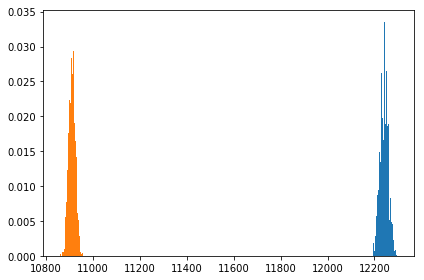

In [27]:
plt.hist(r_trace.get_values('riders_before'), bins=50, normed=True)
plt.hist(r_trace.get_values('riders_after'), bins=50, normed=True)
plt.show()

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


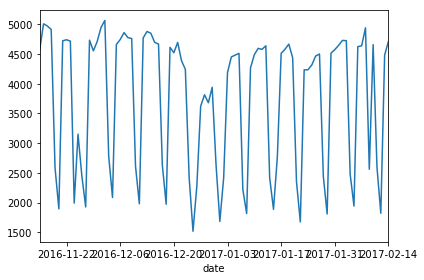

In [28]:
data['R210'].plot()

In [34]:
data.index[int(r_trace.get_values('day_of_shock').mean())]

datetime.date(2016, 12, 23)

So, even though it picks out a day, we can safely assume that this was the model fitting the noise around the holidays. Since we're using 90 days, let's make sure that we're only looking at those stations that are near the actual day, +/- 3-5 days.

In [35]:
r572_trace.get_values('day_of_shock').mean()

46.0

In [38]:
affected = []
for unit, trace in zip(data.columns, saved_traces):
    if 41 < trace.get_values('day_of_shock').mean() < 49:
        affected.append((unit, trace))
len(affected)

198

We could try to limit this further, but we don't really know the underlying causes unless we go back to using some time series modeling, which I'm going to avoid for now. Let's calculate our deltas for these stations, and try to attribute the differences. But first, let's just visual those deltas.

-107.455672727 3149.05865876


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


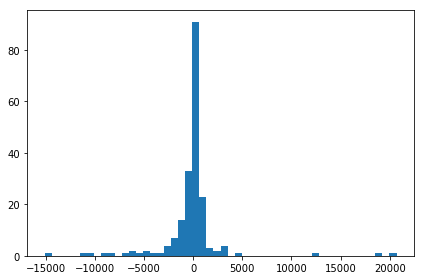

In [61]:
diffs = np.array([(t.get_values('riders_after') - t.get_values('riders_before')).mean()
                  for _, t in affected])
print(diffs.mean(), diffs.std())
_ = plt.hist(diffs, bins=50)

So, we have a whole bunch of roughly zero change stations. Let's only keep those that saw a change of more than one standard deviation of riders in either direction.

In [119]:
more_affected = []
exclude = ['R010', 'R011', 'R012', 'R020', 'R021',
           'R022',
           'R031', 'R032', 'R033', 'R045', 'R046',
           'R047', 'R048', 'R195', 'R293', 'R550']

for unit, trace in affected:
    if unit not in exclude:
        before = trace.get_values('riders_before').mean()
        after = trace.get_values('riders_after').mean()
        more_affected.append((unit, trace))
len(more_affected)

185

*Much* more manageable! We'll say that these stations are the only ones I care about, and the start of our data from it.

Elasticity
------------

I have two choices: I can create the values fo the ~200 stations that had changepoints near the correct day, or just for the 23 that saw changes above some threshold. I'll do the latter, since that's less calculating and the others would show marginal (at best) differences and shouldn't be taken into account.

In [120]:
units = [s[0] for s in more_affected]
print(*units, sep=', ')

R006, R009, R014, R016, R017, R018, R022, R024, R049, R051, R054, R058, R067, R069, R072, R079, R080, R083, R087, R088, R089, R090, R094, R095, R096, R103, R106, R108, R113, R116, R118, R122, R124, R125, R136, R137, R139, R145, R146, R148, R149, R152, R153, R157, R162, R166, R168, R171, R174, R176, R178, R179, R184, R185, R188, R189, R190, R193, R194, R196, R197, R198, R202, R209, R211, R215, R217, R220, R221, R223, R226, R227, R229, R231, R232, R234, R236, R238, R239, R240, R241, R243, R245, R246, R247, R249, R253, R256, R257, R258, R259, R262, R265, R266, R268, R269, R271, R276, R277, R279, R280, R281, R282, R284, R285, R287, R288, R289, R290, R292, R297, R298, R299, R300, R303, R304, R306, R310, R312, R313, R317, R318, R319, R322, R326, R327, R328, R329, R333, R338, R342, R343, R344, R345, R346, R347, R348, R352, R353, R354, R355, R356, R359, R361, R362, R364, R370, R372, R377, R378, R379, R394, R402, R403, R404, R405, R411, R413, R414, R424, R427, R430, R431, R436, R437, R439, R441

     unit station linename   c_a
523  R179   86 ST      456  R249
524  R179   86 ST      456  R250


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


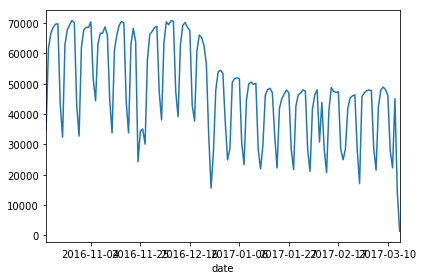

In [125]:
u = 'R179'
print(details[details.unit == u])
data[u].plot()

In [126]:
Q_line = ['R570', 'R571', 'R572']
diffs = []

for unit, trace in more_affected:
    before = trace.get_values('riders_before').mean()
    after = trace.get_values('riders_after').mean()
    diff = after - before
    if np.abs(diff) > 1000:
        print(unit, diff)
        diffs.append((unit, diff))

R014 -9161.6796
R017 -2351.7272
R018 -2176.9924
R022 -10379.6618
R024 -1463.8204
R049 -1907.6908
R051 -5786.0592
R054 -1516.9128
R079 -2449.5902
R080 3361.822
R108 1820.732
R113 -1233.2298
R116 -3249.2052
R166 -1563.811
R171 1333.6228
R176 -1819.073
R178 -6540.5194
R179 -15101.5586
R188 -2337.8804
R189 -1003.1784
R202 -1218.5228
R227 1212.5198
R232 -2890.8548
R236 1581.4444
R257 -1558.9764
R290 1344.621
R300 -1977.6224
R304 -1211.7008
R319 3131.6378
R322 -1416.1274
R463 -1478.0348
R542 1139.9976
R543 2736.9964
R544 1165.6912
R545 1018.0266
R549 2188.0338
R570 20686.4878
R571 19116.9204
R572 12359.6088


In [84]:
# a_units = [a[0] for a in more_affected]
# for u in a_units:
#     print(details[details.unit == u].iloc[0])

In [127]:
added_to_q = diffs[-3][1] + diffs[-2][1] + diffs[-1][1]
added_to_q

52163.017

In [145]:
diff_units = [d[0] for d in diffs]
diff_values = [d[1] for d in diffs]
diff_frame = pd.DataFrame(diff_values, index=diff_units)
diff_frame.columns = ['R570']
diff_frame['R571'] = diff_frame['R572'] = diff_frame.R570
diff_frame

,R570,R571,R572
R014,-9161.6796,-9161.6796,-9161.6796
R017,-2351.7272,-2351.7272,-2351.7272
R018,-2176.9924,-2176.9924,-2176.9924
R022,-10379.6618,-10379.6618,-10379.6618
R024,-1463.8204,-1463.8204,-1463.8204
R049,-1907.6908,-1907.6908,-1907.6908
R051,-5786.0592,-5786.0592,-5786.0592
R054,-1516.9128,-1516.9128,-1516.9128
R079,-2449.5902,-2449.5902,-2449.5902
R080,3361.8220,3361.8220,3361.8220


In [149]:
diff_frame.loc[['R570', 'R571', 'R572']].iloc[:, 0].sum()

52163.017

In [129]:
diff_new = diff_frame / added_to_q
diff_new.loc['R570':'R572'] = 0
diff_new

,R570,R571,R572
R014,-0.175636,-0.175636,-0.175636
R017,-0.045084,-0.045084,-0.045084
R018,-0.041734,-0.041734,-0.041734
R022,-0.198985,-0.198985,-0.198985
R024,-0.028062,-0.028062,-0.028062
R049,-0.036572,-0.036572,-0.036572
R051,-0.110923,-0.110923,-0.110923
R054,-0.029080,-0.029080,-0.029080
R079,-0.046960,-0.046960,-0.046960
R080,0.064448,0.064448,0.064448


In [130]:
# details[(details.unit == 'R012') | (details.unit == 'R031') | (details.unit == 'R293')]  # penn station
# details[details.unit == 'R014']  # fulton
# details[details.unit == 'R020']  # rockefeller center?
# details[details.unit == 'R021']  # bryant park
# details[details.unit == 'R022']  # herald square
# details[details.unit == 'R032']  # times square
# details[(details.unit == 'R046') | (details.unit == 'R047')]  # grand central
# details[details.unit == 'R080']  # 57th & 7th
# details[details.unit == 'R118']  # canal st
# details[details.unit == 'R550']  # PATH?

There are a lot of large stations that are probably affected by holiday traffic, so we shouldn't take those into account... We should try to exclude those stations (and combine their multiple units) when we do our analysis.

In [131]:
diff_new.to_csv('second_avenue_opens.csv')

In [140]:
data.index = pd.DatetimeIndex(data.index)
data.index.get_loc('2017-01-01')

77

In [142]:
u, v = list(zip(*diffs))
print(u)

('R014', 'R017', 'R018', 'R022', 'R024', 'R049', 'R051', 'R054', 'R079', 'R080', 'R108', 'R113', 'R116', 'R166', 'R171', 'R176', 'R178', 'R179', 'R188', 'R189', 'R202', 'R227', 'R232', 'R236', 'R257', 'R290', 'R300', 'R304', 'R319', 'R322', 'R463', 'R542', 'R543', 'R544', 'R545', 'R549', 'R570', 'R571', 'R572')


In [143]:
print(v)

(-9161.6795999999958, -2351.7271999999975, -2176.9924000000028, -10379.661799999994, -1463.8204000000005, -1907.6908000000003, -5786.0592000000033, -1516.9128000000001, -2449.5902000000006, 3361.8220000000001, 1820.732, -1233.229800000001, -3249.2052000000003, -1563.8109999999997, 1333.6228000000001, -1819.0729999999967, -6540.519400000001, -15101.558599999997, -2337.8803999999982, -1003.1783999999998, -1218.5228000000006, 1212.5198, -2890.8548000000001, 1581.4444000000003, -1558.9764000000014, 1344.6209999999992, -1977.6224000000002, -1211.7007999999996, 3131.6377999999986, -1416.1273999999994, -1478.0348000000013, 1139.9975999999997, 2736.9964, 1165.6912000000002, 1018.0266000000001, 2188.0338000000011, 20686.487799999999, 19116.920399999999, 12359.6088)


Final
------

OK, I am pretty sure that this is enough to actually run all of the elasticities that I need. All of the important steps are saved in `run_single.py` for easier usage. For running others, I'll either need to add in some command line parsing or just load the file into a notebook.